In [289]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pickle

In [290]:
# Fake data - expected format!
#n_cal = 1000
#n_classes = 100
#n_test = 500
#pred_cal = softmax(np.random.rand(n_cal,n_classes), axis = 1)
#pred_test = softmax(np.random.rand(n_test,n_classes), axis = 1)
#true_cal = np.eye(n_classes)[np.random.choice(n_classes, n_cal)]
#true_test = np.eye(n_classes)[np.random.choice(n_classes, n_test)]

In [436]:
with open('../../predictions/CIFAR100_softmax_cal_proba.pickle', 'rb') as f:
    pred_cal = pickle.load(f)
with open('../../predictions/CIFAR100_softmax_test_proba.pickle', 'rb') as f:
    pred_test = pickle.load(f)
with open('../../predictions/CIFAR100_softmax_cal_true.pickle', 'rb') as f:
    true_cal = pickle.load(f)
with open('../../predictions/CIFAR100_softmax_test_true.pickle', 'rb') as f:
    true_test = pickle.load(f)

1000 calibration points
10000 test points
100 classes


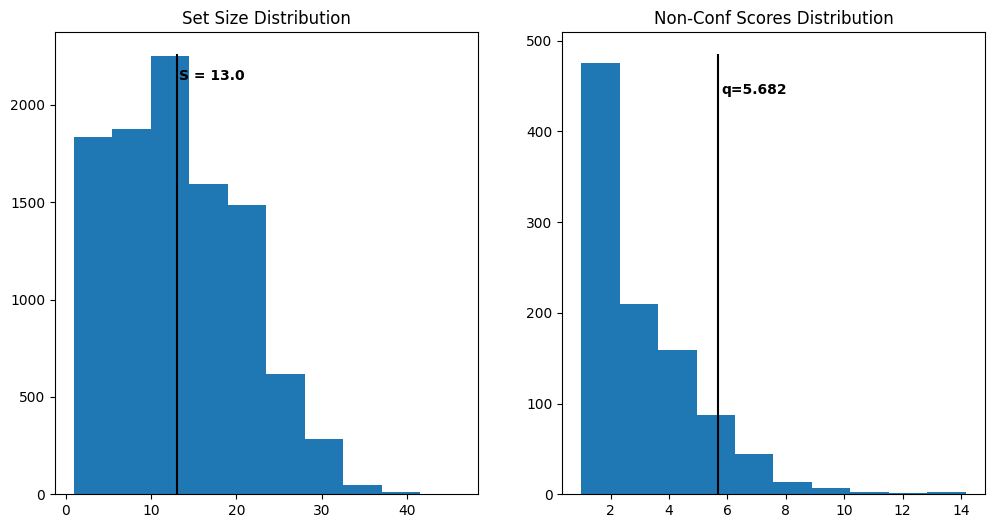

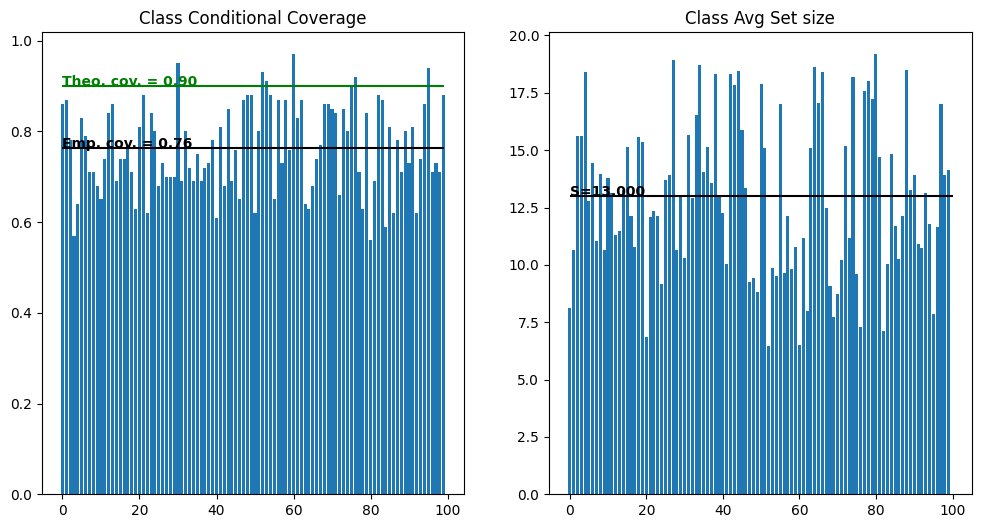

OF=0.0432


In [437]:
# Get non-conformity scores
alpha = 0.1

def get_pvalue(preds):
        return np.array([((cal_scores>= el).sum() + 1)/(len(cal_scores) + 1) for el in preds])

#def cp_classifier(pred_cal, true_cal, pred_test, true_test, method='naive',alpha=0.1):
n_cal, n_classes = pred_cal.shape 
n_test = true_test.shape[0]
print(f'{n_cal} calibration points')
print(f'{n_test} test points')
print(f'{n_classes} classes')

# Get calibration quantile
true_mask = true_cal.astype(bool)
cal_scores = 1 - pred_cal[true_mask]
q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method

# test predictions
test_scores = 1 - pred_test
test_match = test_scores<= qhat
# get p-values 
test_pvalues = np.apply_along_axis(get_pvalue,1,test_scores)
p_values_cal = get_pvalue(cal_scores)

# Set size and scores distribution
set_size = test_match.sum(axis = 1)
    
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].hist(set_size)
axs[0].vlines(set_size.mean(),0,max(np.histogram(set_size, bins=10)[0])+10, color='black')
axs[0].text(set_size.mean()*1.02,max(np.histogram(set_size, bins=10)[0]-10)*0.95,  f'S = {set_size.mean()}', color='black',fontweight='bold')
axs[0].set_title('Set Size Distribution')

axs[1].hist(cal_scores)
axs[1].vlines(qhat,0,max(np.histogram(cal_scores, bins=10)[0])+10, color='black')
axs[1].text(qhat*1.02,max(np.histogram(cal_scores, bins=10)[0]-10)*0.95, f'q={qhat:.3f}', color='black',fontweight='bold')
axs[1].set_title('Non-Conf Scores Distribution')
plt.show()

coverage = test_match[true_test.astype(bool)].sum()/n_test
class_coverage = (test_match & true_test).sum(axis = 0)/true_test.sum(axis=0)

set_size = test_match.sum(axis = 1)

class_size = true_test.copy()
class_size[class_size==1]=test_match.sum(axis = 1)
class_size = class_size.sum(axis=0)/true_test.sum(axis=0)

# Class-wise metrics
fig, axs = plt.subplots(1,2,figsize=(12,6))
# add labels?
axs[0].bar(np.arange(n_classes),class_coverage)
axs[0].hlines(coverage,0,n_classes-1, color='black')
axs[0].hlines(1-alpha,0,n_classes-1, color='green')
axs[0].text(0,coverage, f'Emp. cov. = {coverage:.2f}', color='black',fontweight='bold')
axs[0].text(0,1-alpha, f'Theo. cov. = {1-alpha:.2f}', color='green',fontweight='bold')
axs[0].set_title('Class Conditional Coverage')


axs[1].bar(np.arange(n_classes),class_size)
axs[1].hlines(set_size.mean(),0,100, color='black')
axs[1].text(0,set_size.mean(), f'S={set_size.mean():.3f}', color='black',fontweight='bold')
axs[1].set_title('Class Avg Set size')

plt.show()

# Observed fuzziness
of = np.ma.array(test_pvalues, mask = true_test).mean(axis=1).data.mean()
print(f'OF={of:.4f}')

In [442]:
cal_labels = true_cal.argmax(axis = 1)
test_labels = true_test.argmax(axis = 1)

In [466]:
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 1
k_reg = 0
disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = False # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (pred_cal.shape[1]-k_reg)*[lam_reg,])[None,:]

In [467]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = pred_cal.argsort(1)[:,::-1]; 
cal_srt = np.take_along_axis(pred_cal,cal_pi,axis=1)

cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal),cal_L] - np.random.rand(n_cal)*cal_srt_reg[np.arange(n_cal),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n_cal+1)*(1-alpha))/n_cal, method='higher')
# Deploy
n_val = true_test.shape[0]
val_pi = pred_test.argsort(1)[:,::-1]
val_srt = np.take_along_axis(pred_test,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

In [468]:
empirical_coverage = prediction_sets[np.arange(n_test),test_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.9758
The quantile is: 0.47918039264998935


In [469]:
prediction_sets.sum(axis=1).mean()

99.7446

(array([  1.,   1.,   1.,   3.,   2.,   8.,   9.,  18.,  37., 920.]),
 array([-6.15894888e+02, -5.54276816e+02, -4.92658745e+02, -4.31040673e+02,
        -3.69422601e+02, -3.07804530e+02, -2.46186458e+02, -1.84568386e+02,
        -1.22950315e+02, -6.13322428e+01,  2.85828889e-01]),
 <BarContainer object of 10 artists>)

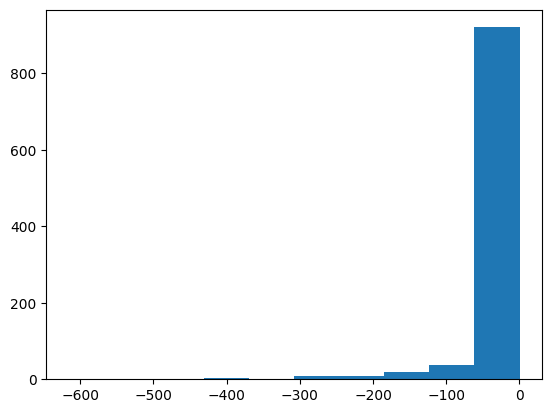

In [461]:
plt.hist(cal_scores)